*Pyomo Optimization Problem Set, Spring 2022*
- Collin Guidry

In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from pyomo.environ import *
from pyomo.opt import SolverFactory

solver = SolverFactory("ipopt")    # loads the non-linear optimiser "IPOPT"

## Question: Profit vs Units Sold

A startup company needs to increase its sales of a product through advertisements. If the company spends $a$ (measured in thousands of dollars) on advertising and charges a price of $p=10+0.38a$ dollars per unit, then it can sell $1000-10p+20\sqrt{a}$  units of the product. The cost per unit of producing the product is $6. Help the company find at least 10 Pareto-optimal solutions and plot the Pareto-optimal frontier between the objectives of maximizing profit and maximizing the number of units sold.

### Part (a) Problem Formulation

Formulate a multi-objective optimization problem, stating clearly your

1. Decision variables
2. Objective function
3. Constraints

<span style="color:green"> 

1. Decision Variables
  - $ a = $ advertising investment (thousands of dollars)
2. Objective function
  - $Max :\ unit sales(a) = f_1(a) $
    - $unit sales(a) = 1000-10p+20\sqrt{a}$
    - substitute:
      - $ unitsales(a)  = 1000-10(10+0.38a)+20\sqrt{a} $
      - $ unitsales(a) = 890-3.8a+20\sqrt{a} $
    - $ Max :\ unitsales(a) = f_1(a) = 890-3.8a+20\sqrt{a} $
  - $Max :\ profit(a) = f_2(a) $
    - $ profit = unitsales * margin - investment$
    - $ profit = unitsales * (price - 6) - a $
    - subsitute:
      - $ profit(a) = unitsales * ((10+0.38a) - 6) - a $
      - $ profit(a) = (890-3.8a+20\sqrt{a}) * (4+0.38a) - a $
    - $Max :\ profit(a) = f_2(a) = -1.444a^2 + 7.6\sqrt{a}*a + 80\sqrt{a} + 322a +3560) $
 
3. Constraints 
  - $ a >0 $ 

In [2]:
# Initialize model

model = ConcreteModel()

model.a = Var(initialize=1)

model.constr1 = Constraint(expr = model.a >= 0)  # can't have negative investment

model.sales = Var()
model.consales = Constraint(expr = model.sales == 890 - 3.8*model.a + 20*model.a**.5 ) # sales constraint

model.profit = Var()
model.conprofit = Constraint(expr = model.profit == -1.444*model.a**2 
                             + 7.6*model.a*model.a**.5 
                             + 80*model.a**.5 
                             +3.524*model.a 
                             + 3560 ) # profit constraint

model.obj_sales = Objective(expr = model.sales, sense = maximize)   # sales objective
model.obj_profit = Objective(expr = model.profit, sense = maximize)   # profit objective

### Part (b) Determine extreme points

As a first step, find the best objective function values for the problem defined in part (a) using Pyomo and IPOPT.

In Pyomo, only one active objective function can be optimized at a time by default

In [3]:
print('Deactivate sales and maximize profit:')
model.obj_sales.deactivate()
solver.solve(model)

sales_min = value(model.sales)
profit_max = value(model.profit)

print("Sales min: {:.2f}".format(sales_min))
print("Profit max: {:.2f}".format(profit_max))

print(40*'-')

print('Deactivate profit and maximize sales:')
model.obj_sales.activate()
model.obj_profit.deactivate()
solver.solve(model)

sales_max = value(model.sales)
profit_min = value(model.profit)

print("Sales max: {:.2f}".format(sales_max))
print("Profit min: {:.2f}".format(profit_min))

Deactivate sales and maximize profit:
Sales min: 898.41
Profit max: 4099.16
----------------------------------------
Deactivate profit and maximize sales:
Sales max: 916.32
Profit min: 3864.18


### Part (c): Find Pareto-optimal points and plot the Pareto frontier.

You need to find at least 10 Pareto-optimal points using Pyomo and IPOPT.

In [4]:
def run_model_with_limit(w1):
    # initialize model
    model = ConcreteModel()
    
    model.a = Var(initialize=1)
    model.constr1 = Constraint(expr= model.a >=0) #can't have negative investment

    model.sales = Var()
    model.consales = Constraint(expr = model.sales == 890 - 3.8*model.a + 20*model.a**.5 )

    model.profit = Var()
    model.conprofit = Constraint(expr = model.profit == -1.444*model.a**2 
                                 + 7.6*model.a*model.a**.5 
                                 + 80*model.a**.5 
                                 +3.524*model.a 
                                 + 3560 )
    model.obj_profit = Objective(expr=model.profit, sense=maximize)
    model.obj_sales = Objective(expr=model.sales, sense=maximize)

    #----------------------------------------------------------
    # Set profit constraint (depending on parameter w1)
    profit_limit = profit_max - (profit_max - profit_min) * w1

    # add profit constraint
    model.constr_profit = Constraint(expr = model.profit <= profit_limit)

    # deactivate sales objective
    model.obj_sales.deactivate()

    # maximize profit with limit
    solver.solve(model)

    # deactivate profit limit constraint
    model.constr_profit.deactivate()

    # add constraint - do not let current level of profit decrease
    model.constr_profit1 = Constraint(expr = model.profit >= value(model.profit))

    # deactivate profit
    model.obj_profit.deactivate()

    # reactivate sales
    model.obj_sales.activate()

    solver.solve(model)

    profit = value(model.profit)
    sales = value(model.sales)
    investment = value(model.a)
    
    return investment, profit, sales

In [5]:
max_bpt = 10
breakpoints = np.array([*range(0,max_bpt+1)])
breakpoints= breakpoints/max_bpt


investment_ = []
profit_ = []
sales_ = []

# iterate through weights and store the model's results
for i in breakpoints:
  investment, profit, sales = run_model_with_limit(i)
  investment_.append(investment)
  profit_.append(profit)
  sales_.append(sales)

df = pd.DataFrame()
df['Investment'] = investment_
df['Profit'] = profit_
df['Sales'] = sales_
df['pct of potenital profit sacrificed'] = breakpoints

df

,Investment,Profit,Sales,pct of potenital profit sacrificed
0,23.053497,4099.157229,898.424826,0.0
1,18.030012,4075.659825,906.409478,0.1
2,15.926232,4052.162381,909.295686,0.2
3,14.303485,4028.664936,911.286654,0.3
4,12.929759,4005.167492,912.782864,0.4
5,11.715341,3981.670048,913.937064,0.5
6,10.614374,3958.172603,914.824795,0.6
7,9.599774,3934.675159,915.487863,0.7
8,8.654075,3911.177714,915.950133,0.8
9,7.765359,3887.680270,916.224423,0.9


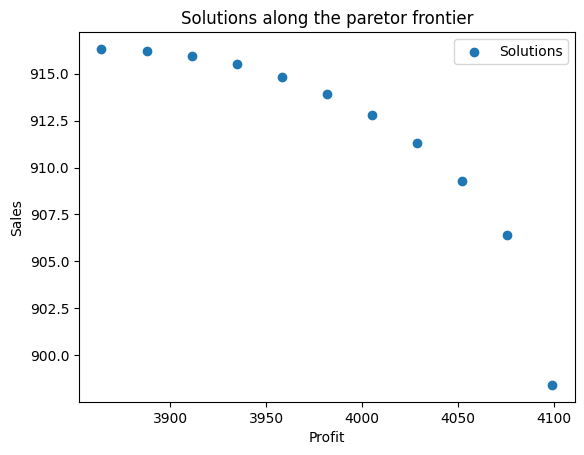

In [7]:
plt.scatter(df['Profit'], df['Sales'], label = 'Solutions')
plt.legend()
plt.xlabel('Profit')
plt.ylabel('Sales')
plt.title('Solutions along the paretor frontier')
plt.show()

### Part (d): Discussion 

Suppose the startup company now decides that although both objectives are important, maximizing the number of units sold is more important than maximizing profit. What suggestions would you give to the company based on your results in part (b) and (c)?

<span style="color:green"> 
-  As each of the ten solutions are pareto-optimal, no particular solution is dominant over any of the other 9 solutions. For this reason, choosing the optimal point is dependent on what percentage of profit the company is willing to sacrifice to achieve a higher number of units sold.
- These solutions were the result of **maximizing profit before sales.** If the company wishes to prioritize sales, they should repeat this weighed sum method, but **maximize sales before profit**.
- To decide what percent of potential sales they should sacrifice, they should analyze and compare the resulting solutions to better understand the compromise between the two objectives